# Segmentation

This notebook is for segmenting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import cellpose
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
import numpy as np

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/ND0000'
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/243648 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0203K1F1P1R1,Ok,r02c03f01p01-ch1sk1fk1fl1.tiff,2,3,1,1,0,1,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
1,0203K1F1P1R2,Ok,r02c03f01p01-ch2sk1fk1fl1.tiff,2,3,1,1,0,2,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
2,0203K1F1P1R3,Ok,r02c03f01p01-ch3sk1fk1fl1.tiff,2,3,1,1,0,3,1,...,0,0.135205805,0,2023-08-04T15:28:16.767+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
3,0203K1F1P2R1,Ok,r02c03f01p02-ch1sk1fk1fl1.tiff,2,3,1,2,0,1,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
4,0203K1F1P2R2,Ok,r02c03f01p02-ch2sk1fk1fl1.tiff,2,3,1,2,0,2,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243643,0310K376F9P2R2,Ok,r03c10f09p02-ch2sk376fk1fl1.tiff,3,10,9,2,375,2,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.533+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243644,0310K376F9P2R3,Ok,r03c10f09p02-ch3sk376fk1fl1.tiff,3,10,9,2,375,3,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.8+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243645,0310K376F9P3R1,Ok,r03c10f09p03-ch1sk376fk1fl1.tiff,3,10,9,3,375,1,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.08+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243646,0310K376F9P3R2,Ok,r03c10f09p03-ch2sk376fk1fl1.tiff,3,10,9,3,375,2,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.097+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [8]:
# metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
metadata_path = glob.glob(os.path.join(base_dir, 'Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
# TEMP FIX FOR BUG IN ASSAY LAYOUT READER - ends up displaying more rows cols then there are so
assay_layout = assay_layout.loc[[idx for idx in assay_layout.index if str(idx[0]) in list(metadata['Row'].unique()) and str(idx[1]) in list(metadata['Col'].unique())]]
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Cell Count Staining Infection
Row Column                              
2   3           50000    False     False
    4           50000    False      True
    9           50000     True     False
    10          50000     True      True
3   3           25000    False     False
    4           25000    False      True
    9           25000     True     False
    10          25000     True      True

### Define row and column of choice

In [9]:
row = 2
column = 10

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [10]:
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='max_proj',
                             set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (2, 10, 'max_proj', 1, None) 


Stitching images together:   0%|          | 0/1128 [00:00<?, ?it/s]

# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [11]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img, ):
    masks, flows, styles, diams = model.eval(img, diameter=350, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

/bin/bash: /home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
/bin/bash: /home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Jun 27 15:25:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage 

INFO:cellpose.core:TORCH CUDA version not installed/working.
INFO:cellpose.core:TORCH CUDA version not installed/working.
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto << model set to be used


>>> GPU activated? NO


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  30.000 (mean diameter of training ROIs)


In [3]:
from skimage import io

In [4]:
images = io.imread('/home/dayn/Downloads/MAX_ND002-1st-C1-1.tif')

In [5]:
images.shape

(9, 2160, 2160, 4)

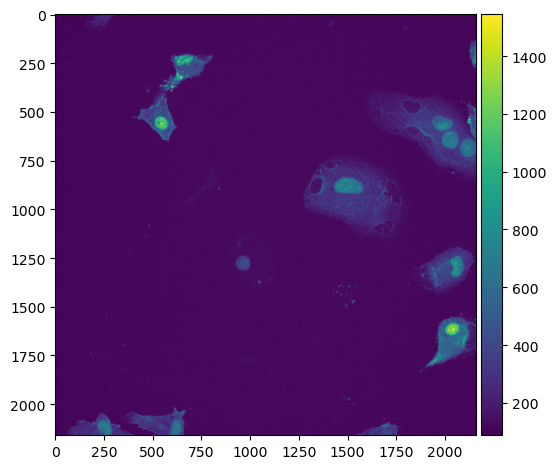

In [8]:
io.imshow(images[0,...,1])

In [9]:
img = images[0,...,1]

In [10]:
masks, flows, styles, diams = model.eval(img, diameter=300, channels=[0,0],
                                             flow_threshold=0.4, cellprob_threshold=0) 

INFO:cellpose.models:~~~ FINDING MASKS ~~~

KeyboardInterrupt



In [ ]:
io.imshow(masks)

# Testing ND0000

In [12]:
images

dask.array<amax-aggregate, shape=(376, 1, 6048, 6048), dtype=uint16, chunksize=(1, 1, 2160, 2160), chunktype=numpy.ndarray>

In [13]:
%%time
img = images[0,0,...].compute().compute()

CPU times: user 1min 33s, sys: 12.2 s, total: 1min 45s
Wall time: 6.67 s


In [19]:
masks_stack = []
for t in tqdm(range(len(images)), total = 376):
    masks, flows, styles, diams = model.eval(images[t,0,...].compute().compute(), diameter=75, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    masks_stack.append(masks)
masks_stack = np.stack(masks_stack, axis = 0)

  0%|          | 0/376 [00:00<?, ?it/s]

INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.89 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.13 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.90 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.04 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 16.32 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.37 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 15.72 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.63 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.77 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.75 sec
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 14.92 sec
INFO:cellp

NameError: name 'np' is not defined

In [21]:
masks_stack = np.stack(masks_stack, axis = 0)

In [ ]:
np.save('/mnt/DATA/macrohet/labels/ND0000/dev/ND0000_2_10_cellpose_default.npy', masks_stack)

In [ ]:
reload(napari)

In [15]:
viewer = napari.Viewer(title = 'testing cellpose on ND0000')

viewer.add_image(img)
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7fbe774448e0>

In [16]:
viewer.add_image(img)

<Image layer 'img [1]' at 0x7fbe56136c70>

In [26]:
!napari

/bin/bash: napari: command not found


In [23]:
viewer = napari.Viewer(title = 'testing cellpose on ND0000')


In [ ]:
segment()

In [7]:
import dask.array as da
from tqdm.auto import tqdm

In [ ]:
mask_stack = []
for n, timepoint in tqdm(enumerate(images), total = len(images)):
    ### extract GFP channel and lowest Z plane from single time point
    gfp_z0_frame = timepoint[0,0,...]
    masks = segment(frame)
    mask_stack.append(masks)
mask_images = da.stack(mask_stack, axis = 0) 

In [31]:
mask_images = da.stack(mask_stack, axis = 0) 

# Testing different segmentation parameters 

In [36]:
### average cell diameter
diameters = [200, 250, 300]
### flow threshold, larger value means more ROIs (maybe ill fitting), lower means fewer ROIs 
flow_thresholds = [0.0, 0.4, 0.6, 0.8]
### cellprob_threshold, larger is is fewer ROIs, lower means more...? 
# cellprobs_thresholds = [-0.2, 0.0, 0.2]

In [34]:
import itertools

In [58]:
mask_dict = dict()
params = list(itertools.product(diameters, flow_thresholds))
for diameter, flow_threshold in tqdm(params, total = len(params)):
    mask_stack = []
    for timepoint in tqdm(images, total = len(images), leave = False):
        ### extract GFP channel and lowest Z plane from single time point
        gfp_z0_frame = timepoint[0,0,...]
        masks, flows, styles, diams = model.eval(gfp_z0_frame, diameter=diameter, channels=[0,0],
                                             flow_threshold=flow_threshold, cellprob_threshold=0)        
        mask_stack.append(masks)
    mask_images = da.stack(mask_stack, axis = 0) 
    mask_dict[(diameter, flow_threshold)] = mask_images

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [59]:
mask_dict

{(200,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.4): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.8): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.4): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.8): dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (300,
 

In [62]:
import numpy as np

In [63]:
np.save('mask_dict.npy', mask_dict)

# Testing different segmentation parameters 

In [8]:
### average cell diameter
# diameters = [200, 250, 300]
diameters = [150, 225, 275, 325, 375]
### flow threshold, larger value means more ROIs (maybe ill fitting), lower means fewer ROIs 
# flow_thresholds = [0.0, 0.4, 0.6, 0.8]
flow_thresholds = [0.1, 0.2, 0.3, 0.5, 1, 1.2, 1.5]

### cellprob_threshold, larger is is fewer ROIs, lower means more...? 
# cellprobs_thresholds = [-0.2, 0.0, 0.2]

In [16]:
import itertools, os
import numpy as np

In [10]:
params = list(itertools.product(diameters, flow_thresholds))
len(params)

35

In [17]:
np.save(f'd{diameter}_ft{flow_threshold}_masks.npy', mask_images)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [22]:
for diameter, flow_threshold in tqdm(params, total = len(params)):
    if os.path.exists(f'd{diameter}_ft{flow_threshold}_masks.npy'):
        print(f'Found d{diameter}_ft{flow_threshold}_masks.npy, skipping to next params')
        continue
    mask_stack = []
    for timepoint in tqdm(images, total = len(images), leave = False):
        ### extract GFP channel and lowest Z plane from single time point
        gfp_z0_frame = timepoint[0,0,...]
        masks, flows, styles, diams = model.eval(gfp_z0_frame, diameter=diameter, channels=[0,0],
                                             flow_threshold=flow_threshold, cellprob_threshold=0)        
        mask_stack.append(masks)
    mask_images = da.stack(mask_stack, axis = 0) 
    np.save(f'd{diameter}_ft{flow_threshold}_masks.npy', mask_images)
    mask_dict[(diameter, flow_threshold)] = mask_images

  0%|          | 0/35 [00:00<?, ?it/s]

Found d150_ft0.1_masks.npy, skipping to next params
Found d150_ft0.2_masks.npy, skipping to next params
Found d150_ft0.3_masks.npy, skipping to next params
Found d150_ft0.5_masks.npy, skipping to next params
Found d150_ft1_masks.npy, skipping to next params
Found d150_ft1.2_masks.npy, skipping to next params
Found d150_ft1.5_masks.npy, skipping to next params
Found d225_ft0.1_masks.npy, skipping to next params
Found d225_ft0.2_masks.npy, skipping to next params
Found d225_ft0.3_masks.npy, skipping to next params
Found d225_ft0.5_masks.npy, skipping to next params
Found d225_ft1_masks.npy, skipping to next params
Found d225_ft1.2_masks.npy, skipping to next params
Found d225_ft1.5_masks.npy, skipping to next params
Found d275_ft0.1_masks.npy, skipping to next params
Found d275_ft0.2_masks.npy, skipping to next params
Found d275_ft0.3_masks.npy, skipping to next params
Found d275_ft0.5_masks.npy, skipping to next params
Found d275_ft1_masks.npy, skipping to next params
Found d275_ft1.2_m

  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1701: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
mask_dict = dict()
mask_dict[(diameter, flow_threshold)] = mask_images

In [62]:
import numpy as np

In [63]:
np.save('mask_dict.npy', mask_dict)

In [57]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
viewer.add_labels(mask_images, 
                 )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'mask_images' at 0x7f995d5e5df0>